In [ ]:
!wget https://raw.githubusercontent.com/abcavusoglu/dataset/main/monthly-car-sales.csv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline
!pip install sktime

In [ ]:

from statsmodels.tsa.stattools import adfuller
from datetime import datetime

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

dataset_path_csv = 'https://raw.githubusercontent.com/abcavusoglu/dataset/main/monthly-car-sales.csv'
df = pd.read_csv(dataset_path_csv, sep=';')
df

# load dataset
y = pd.read_csv(dataset_path_csv, header=0, index_col=0,sep=';')
y

,Monthly car sales in Quebec 1960-1968
Month,
1960-01,6550
1960-02,8728
1960-03,12026
1960-04,14395
1960-05,14587
...,...
1968-08,16722
1968-09,14385
1968-10,21342


In [ ]:
df = df.rename(columns={'Monthly car sales in Quebec 1960-1968': 'Sales'})
y = y.rename(columns={'Monthly car sales in Quebec 1960-1968': 'Sales'})
y

This dataset describes the monthly Car Sales in Quebec from 1960 to 1969.


**Data source:** https://www.kaggle.com/datasets/dinirimameev/monthly-car-sales-in-quebec-1960?resource=download

**Plotting**

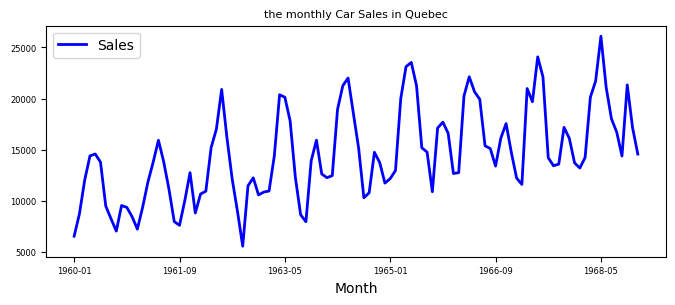

In [ ]:
import matplotlib.pyplot as plt
ax1 = y.plot(color='blue', figsize=(8, 3), linewidth=2, fontsize=6)
ax1.set_title('the monthly Car Sales in Quebec', fontsize=8);

Sales are inclining over time, with strong periodicity.

Sales seem peak during spring, and drop towards the end of each year.


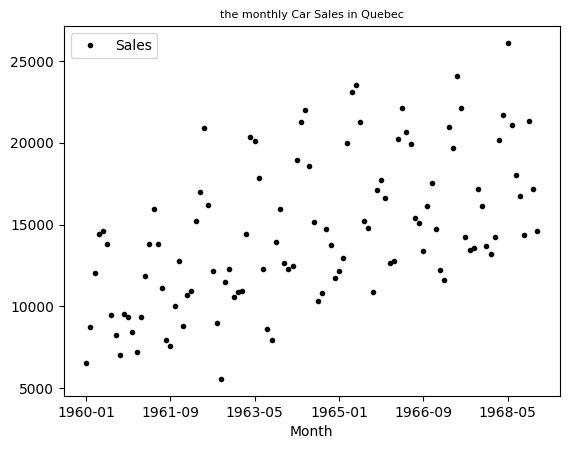

In [ ]:
# using dots instead of line
from matplotlib import pyplot
ax1 = y.plot(style='k.')
ax1.set_title('the monthly Car Sales in Quebec', fontsize=8);
pyplot.show()

Upward trend can also be seen from the plot with dots. It is also possible to conclude that there is a significant variation in the data.

  Certain linear time series forecasting techniques rely on the assumption that observations follow a normal distribution. This assumption can be verified using statistical hypothesis tests. However, density plots can also be used as an initial method to assess the distribution of observations.


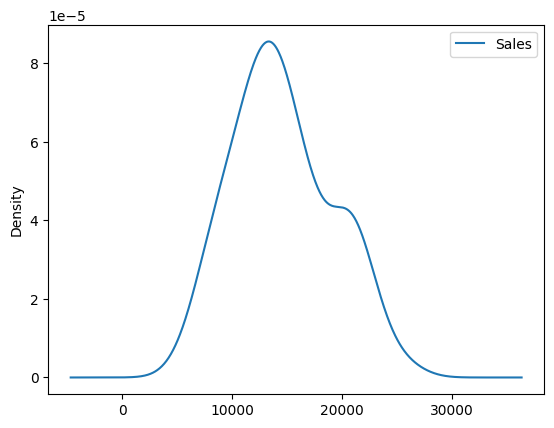

In [ ]:
# time series density plots
y.plot(kind='kde')
pyplot.show()

Plot does not have skewness towards sides, however, it is not exactly normal distribution.


Time series modeling involves the assumption that there is a connection between a current observation and the previous one. The earlier observations in a time series are referred to as lags, and we can measure the degree and nature of this connection using an autocorrelation plot.

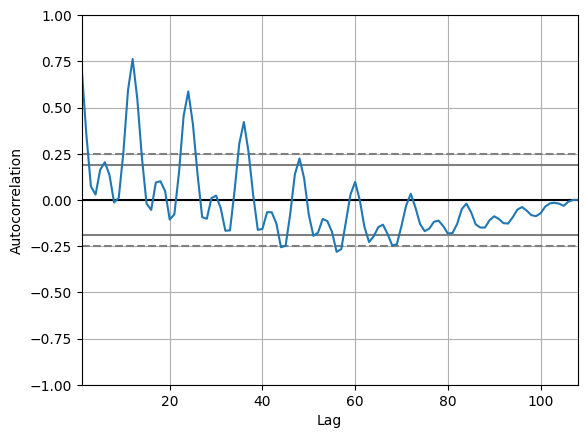

In [ ]:
# autocorrelation plot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y)
pyplot.show()

We can observe that for car sales, there seems to be cycles of positive and negative correlation. This describes how an observation is connected to past observations in both similar and different seasons or times of year. Wawes in the autocorrelation plot is an indicator of seasonality in the dataset.



**Train Test splitting**

In [ ]:
data =y
data.index = pd.to_datetime(data.index)
data.index = data.index.to_period('M')

In [ ]:
from sktime.split import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=0.33)

**Decomposition of Time series**

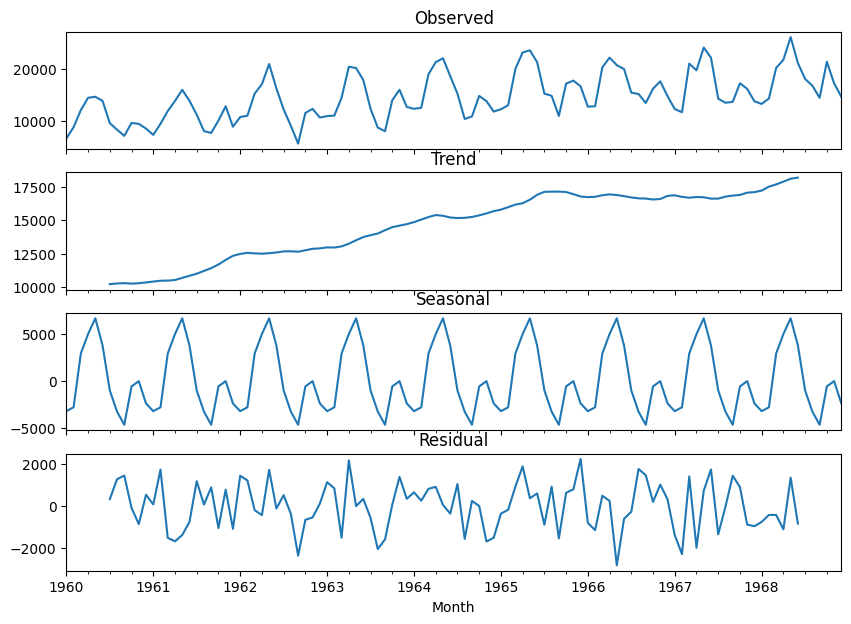

In [ ]:
# decomposition of time series
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
result = seasonal_decompose(y, model='additive', period=12)

# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
result.observed.plot(ax=axes[0], title='Observed')
result.trend.plot(ax=axes[1], title='Trend')
result.seasonal.plot(ax=axes[2], title='Seasonal')
result.resid.plot(ax=axes[3], title='Residual')


plt.show()

**Key Takeaways:**

The trend line confirms a consistent upward trend in the data, and approximately exhibits linear behavior so we will use an additive method in our ETS model.

The seasonality subplot indicates that the recurring spikes in sales vary slightly in their magnitude each year, affirming the presence of seasonality in our dataset. This suggests that any ARIMA models used for analysis will require seasonal differencing.

The varying magnitude also indicates that any ETS models will utilize a multiplicative method for the seasonal component.

The residual component represents random variability that remains after removing the trend and seasonality. Residuals approximately wave around zero.


**Forecasts with ETS**

Since seasonality patterns are clear, there is no need for ThetaForecaster, I will use ExponentialSmoothing and explicitly specify the smoothing parameters and components of the ETS model.

Trend is linear so additive method will be used.

Seasonality has varying magnitude so multiplicative method will be used.

residual has also varying magniture so multiplicative method will be used.

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

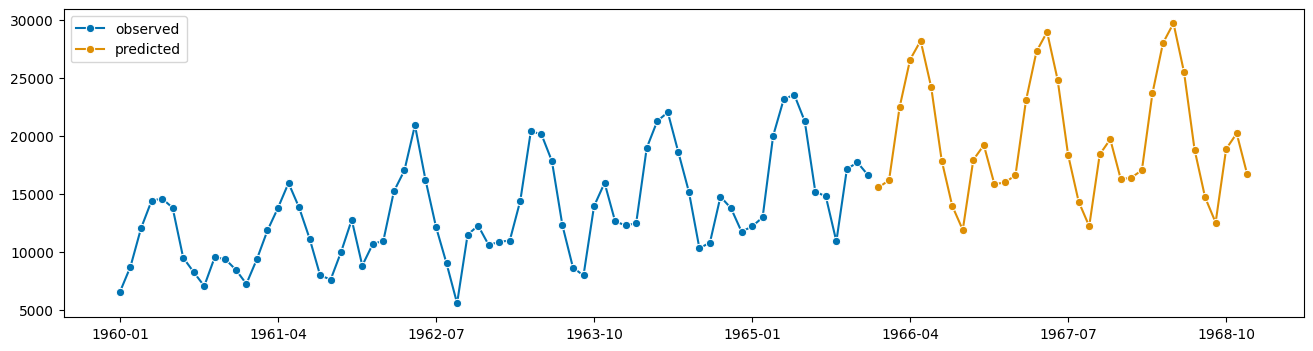

In [ ]:
# December 1966
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(error='mul', trend='add', damped_trend=False, seasonal='mul', sp=12, n_jobs=-1)

y_train=y[:-36]

fh = np.arange(1,37)  #corresponds to y_test

forecaster.fit(y_train)

# obtaining the batch of forecasts for Jan 1966 - Dec 1968
y_pred = forecaster.predict(fh)

# plotting predictions and past data
from sktime.utils.plotting import plot_series
plot_series(y_train, y_pred, labels=["observed", "predicted"])

ETS predicts an increase in the trend for the 3 consecutive years, with seasonal variation.

**Gradient Boosting**

In [ ]:
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import xgboost as xgb

In [ ]:
df = df.set_index('Month')
df.index = pd.to_datetime(df.index)

In [ ]:
df_train, df_test = temporal_train_test_split(df, test_size=0.33)

In [ ]:
# Feature Creation
def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
df.columns

Index(['Sales', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

In [ ]:
df_train = create_features(df_train)
df_test = create_features(df_test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear']
TARGET = 'Sales'

X_train = df_train[FEATURES]
y_train = df_train[TARGET]

X_test = df_test[FEATURES]
y_test = df_test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

Since data is trained now, we can check feature importance.

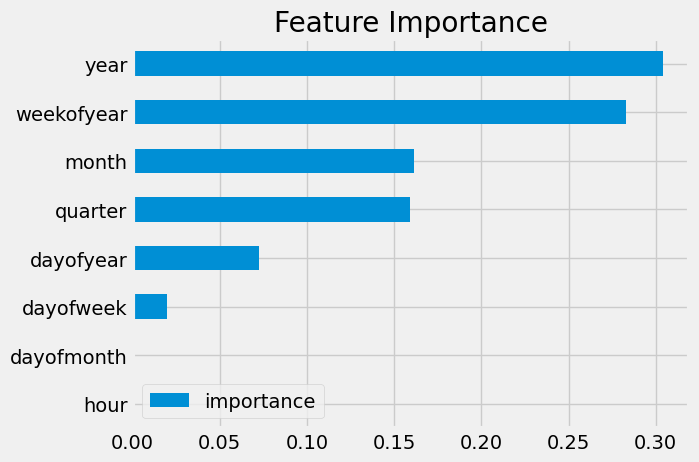

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

As seen, most important features are year and week of the year.

Forecast on test data

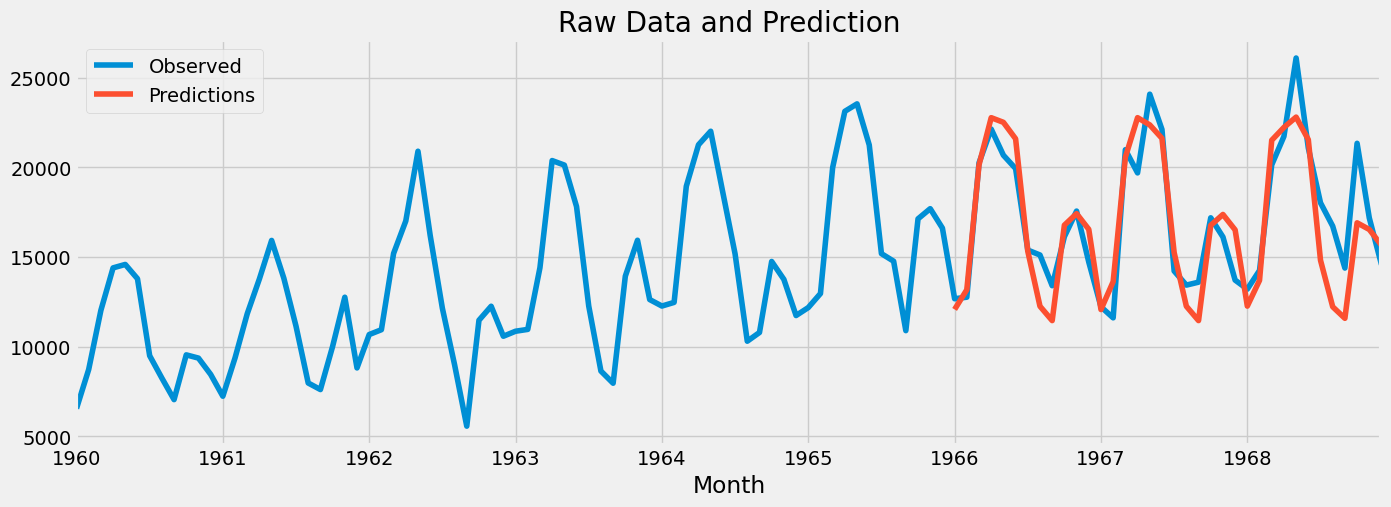

In [ ]:
df_test['prediction'] = reg.predict(X_test)
df = df.merge(df_test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Sales']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax)
plt.legend(['Observed', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

xGBoost predicts a constant trend for the three consecutive years, with seasonal variation.

**Stationary**

Before using and ARIMA models, We must ensure that data is stationary, which means that the statistical properties of the data (such as the mean and variance) do not change over time. This is important because many time series models, including SARIMA, require stationary data in order to provide accurate forecasts.



First we test whether data is stationary:

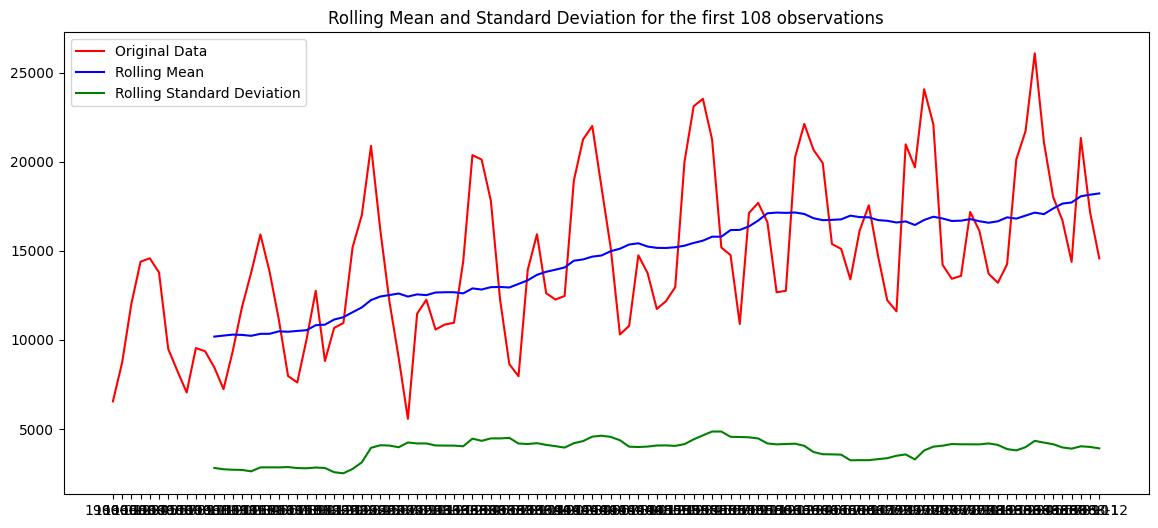

Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


In [ ]:
def stationarity(ts, window, n):
    roll_mean = ts.rolling(window).mean()
    roll_std = ts.rolling(window).std()

    plt.figure(figsize = (14, 6))

    plt.plot(ts[:n], label = 'Original Data', color = 'red')
    plt.plot(roll_mean[:n], label = 'Rolling Mean', color = 'blue')
    plt.plot(roll_std[:n], label = 'Rolling Standard Deviation', color = 'green')
    plt.title("Rolling Mean and Standard Deviation for the first %d observations"%(n))
    plt.legend(loc = 'best')
    plt.show(block = False)

    dftest = adfuller(ts)
      #Ho: It is non stationary
      #H1: It is stationary
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

stationarity(y,12,len(y))

Resulted P-value suggests weak evidence against null hypothesis. Time series has a unit root, indicating it is non-stationary.


**Differencing**

Typically, non-stationary series can be rectified through a straightforward adjustment, such as differencing. Differencing the series aids in eliminating its trend or cycles. The concept behind differencing is that if the original data series does not demonstrate constant characteristics over time, the change from one period to another may exhibit such properties. The difference is computed by subtracting the values of one period from the values of the previous period.


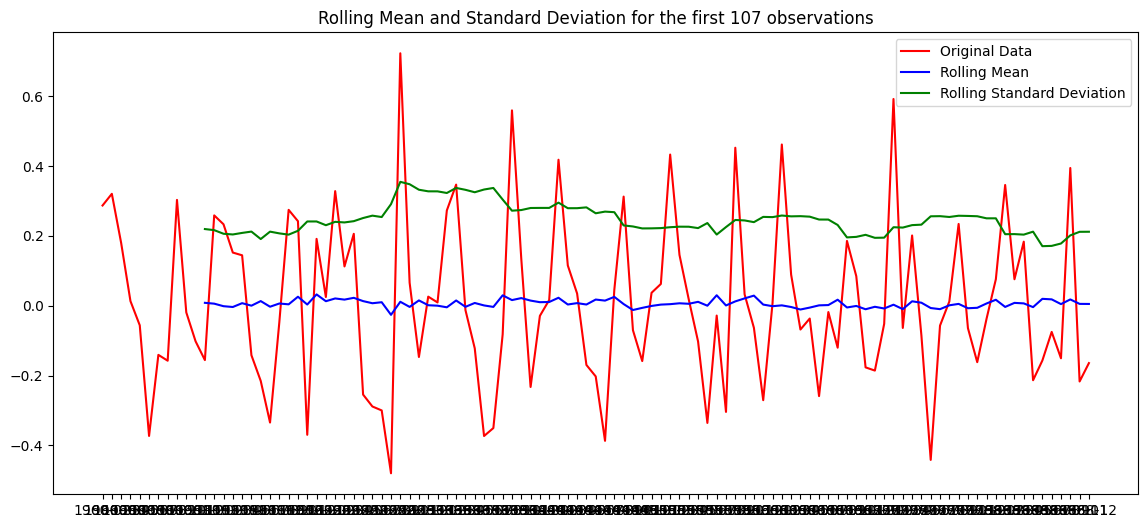

Test Statistic                 -4.193835
p-value                         0.000675
#Lags Used                     12.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [ ]:
ts_log = np.log(y)
ts_log_diff = ts_log - ts_log.shift() #differencing step
ts_log_diff.dropna(inplace = True)

stationarity(ts_log_diff,12,len(ts_log_diff))

P-value suggests strong evidence against the null hypothesis, we reject the null hypothesis. Data has no unit root and is stationary

In [ ]:
y.index = pd.to_datetime(y.index)
y.index = y.index.to_period('M')

**ARIMA MODELS**
Arima (AutoRegressive Integrated Moving Average) models are a class of statistical models commonly used for time series analysis and forecasting. They are a combination of autoregressive (AR) and moving average (MA) models, and are capable of capturing both linear and non-linear patterns in the data.

The advantages of Arima models include their ability to handle time series data, which can exhibit complex and changing patterns over time. They are also flexible in that they can be applied to both stationary and non-stationary time series data.

When constructing an ARIMA model, we utilize the standard notations p, d, and q to represent the model's components. These parameters are incorporated as part of the initialization of the ARIMA model, denoted as ARIMA (p,d,q).

The roles of the standard notations are delineated as follows:

p: Signifying the order of the Auto Regression (AR) component, it denotes the count of lag observations within the ARIMA model. Lag refers to the temporal distance between two data points/observations in the time series. The optimal value for p is determined through analysis using a Partial Autocorrelation Function (PACF) plot.

d: This parameter represents the total number of differencing steps employed to render the time series stationary. If the time-series data is already stationary, differeing is unnecessary.

q: Describing the order of the Moving Average (MA) component, q indicates the forecast errors incorporated into the final ARIMA Model. The most suitable value for q is ascertained through an AutoCorrelation Function (ACF) plot.

**Seasonal Arima**

Seasonal ARIMA, or SARIMA, is an extension of the ARIMA model that takes into account seasonality in the time series data. It is used when the time series data exhibits a repetitive pattern at regular intervals, such as daily, weekly, monthly, or yearly cycles.

I will use both models and compare the results.

**ARIMA**

Getting the best ‘p’ and ‘q’ values

Since we have performed differencing only once, we will fix d=1.

We get the best value of q using an Autocorrelation Function (ACF) plot.

We get the best value of p using a Partial Autocorrelation Function (PACF) plot.

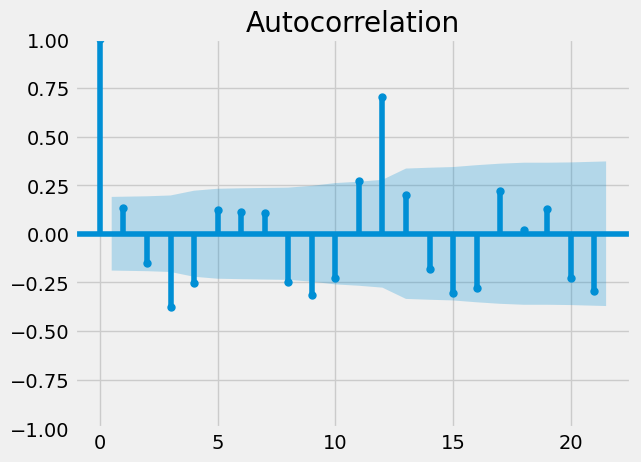

In [ ]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_log_diff['Sales'])
pyplot.show()

The lag number one is notable in the ACF plot, as indicated by the position of the red arrow. It slightly exceeds the significance line (the blue line). This lag will be chosen as the optimal value for q. Consequently, q=1.

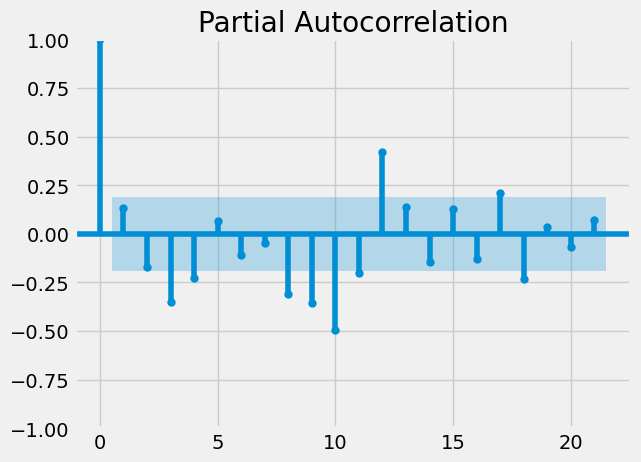

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ts_log_diff['Sales'])
pyplot.show()

We can see in the PACF plot that lags 1 and 13 are prominent, as indicated by the red arrow. These points surpass the significance line (the blue shaded line). We choose lag number one as the optimal value for p, as it is the first lag that exceeds the blue line. Therefore, p=1.


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#train test split for differences
ts=ts_log_diff['Sales']
ts.index = pd.to_datetime(ts.index)
ts.index = ts.index.to_period('M')

diff_train, diff_test = temporal_train_test_split(ts_log_diff['Sales'], test_size=0.33)

In [ ]:
arima_model=ARIMA(diff_train,order=(1,1,1))
arima_model=arima_model.fit()

<Axes: xlabel='Month'>

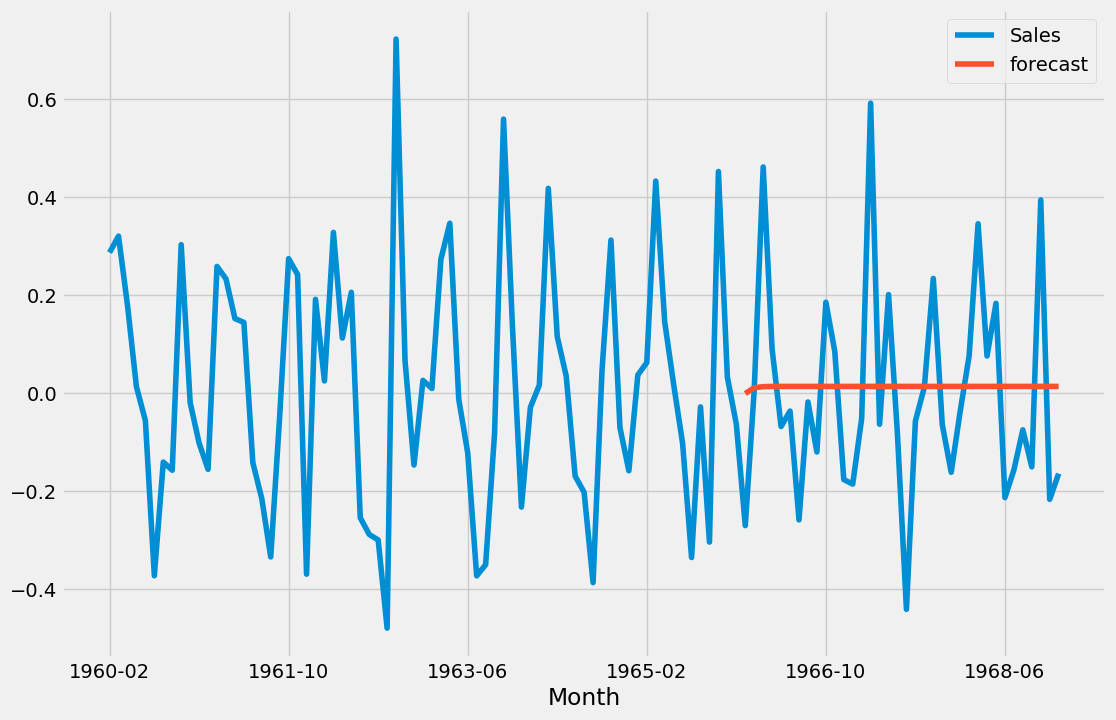

In [ ]:
ts_log_diff['forecast']=arima_model.predict(start=71,end=108,dynamic=True)
ts_log_diff[['Sales','forecast']].plot(figsize=(12,8))

We observe that our forecast closely aligns with the provided data across all prediction processes. While the predicted values are generally satisfactory, they do not encompass the data that has been used post-differencing. This suggests that the upcoming predictions may not factor in the impact of seasonality or other influencing components. To address this, we can employ the SARIMAX model.


In [ ]:
import statsmodels.api as sm
sarima_model=sm.tsa.statespace.SARIMAX(diff_train,order=(1, 1, 1),seasonal_order=(1,1,1,12))
sarima_results=sarima_model.fit()

<Axes: xlabel='Month'>

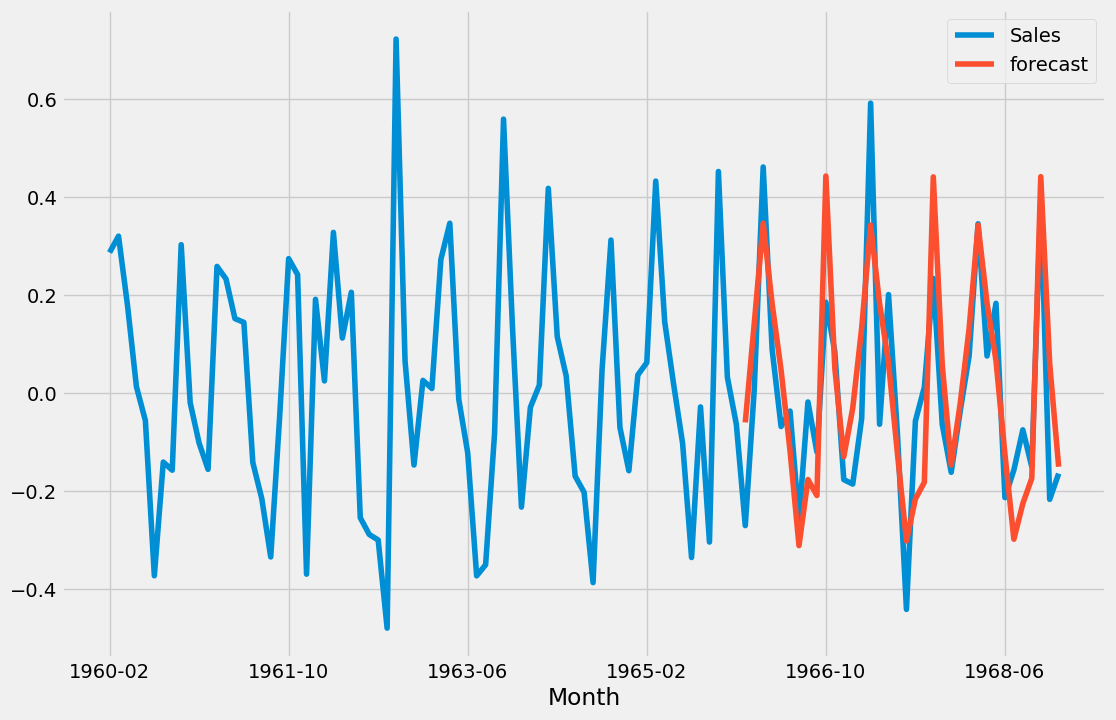

In [ ]:
ts_log_diff['forecast']=sarima_results.predict(start=71,end=108,dynamic=True)
ts_log_diff[['Sales','forecast']].plot(figsize=(12,8))

SARIMA model makes forecasts for our data better.

That is why we will not include ARIMA in the final comparison.

**Evaluation**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
mape = MeanAbsolutePercentageError(symmetric=False)

# Calculate MSE, MAE, RMSE, and R2 for ETS model

mse_ets = mean_squared_error(y_test, y_pred)
mae_ets = mean_absolute_error(y_test, y_pred)
rmse_ets = np.sqrt(mse_ets)
r2_ets = r2_score(y_test, y_pred)
mape_ets=mape(y_test, y_pred)

# Calculate MSE, MAE, RMSE, and R2 for SARIMA model

mse_sarima = mean_squared_error(diff_test, ts_log_diff['forecast'].iloc[-36:])
mae_sarima = mean_absolute_error(diff_test, ts_log_diff['forecast'].iloc[-36:])
rmse_sarima = np.sqrt(mse_sarima)
r2_sarima = r2_score(diff_test, ts_log_diff['forecast'].iloc[-36:])
#mape_sarima=mape(diff_test, ts_log_diff['forecast'].iloc[-36:])

# Calculate MSE, MAE, RMSE, and R2 for xgboost model

mse_xgboost = mean_squared_error(df_test['Sales'], df_test['prediction'])
mae_xgboost = mean_absolute_error(df_test['Sales'], df_test['prediction'])
rmse_xgboost = np.sqrt(mse_xgboost)
r2_xgboost = r2_score(df_test['Sales'], df_test['prediction'])
mape_xgboost=mape(df_test['Sales'], df_test['prediction'])

# Print the metrics for each model
print("ETS Model Metrics:")
print("MSE:", mse_ets)
print("MAE:", mae_ets)
print("RMSE:", rmse_ets)
print("R-squared:", r2_ets)
print("MAPE:", mape_ets)
print("\n")

print("SARIMA Model Metrics:")
print("MSE:", mse_sarima)
print("MAE:", mae_sarima)
print("RMSE:", rmse_sarima)
print("R-squared:", r2_sarima)
print("\n")

print("xgboost Model Metrics:")
print("MSE:", mse_xgboost)
print("MAE:", mae_xgboost)
print("RMSE:", rmse_xgboost)
print("R-squared:", r2_xgboost)
print("MAPE:", mape_xgboost)


ETS Model Metrics:
MSE: 12105923.341774022
MAE: 3051.2434726552397
RMSE: 3479.3567425278516
R-squared: 0.130415319825534
MAPE: 0.1792587460611855


SARIMA Model Metrics:
MSE: 0.0197509348773856
MAE: 0.11887085538470471
RMSE: 0.14053801933066226
R-squared: 0.5746748633911083


xgboost Model Metrics:
MSE: 3620682.113255289
MAE: 1478.4707573784722
RMSE: 1902.8090059843864
R-squared: 0.7399215566974567
MAPE: 0.08853308529999551


/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


**Conclusion**


Since SARIMA model uses differencing, the absolute errors do not reflect the original data. Thus it is more meaningful to evaluate it based on MAPE AND R-squared.


Based on the evaluation metrics, Gradient Boosting seems to be the best performing model, given lowest errors and highest R-squared.

In [1]:
import time

def christmas_tree_animation():
    tree_height = 10

    for i in range(tree_height):
        spaces = " " * (tree_height - i - 1)
        stars = "*" * (2 * i + 1)
        print(f"{spaces}\033[1;32m{stars}\033[1;0m")
        time.sleep(0.2)

    for _ in range(3):
        print(" " * (tree_height - 1) + "| |")
        time.sleep(0.3)

    print("\nHappy New Year!")

christmas_tree_animation()

         *
        ***
       *****
      *******
     *********
    ***********
   *************
  ***************
 *****************
*******************
         | |
         | |
         | |

Happy New Year!
